**A Keras-Tensorflow experimentation of Automatic Signature Verification Using Siamese Networks**

##### Import Libraries

In [1]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras import models
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer, InputSpec
from keras.regularizers import l2
from keras import backend as K
import keras.backend.tensorflow_backend as tfback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils.multi_gpu_utils import multi_gpu_model
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
# tf.debugging.set_log_device_placement(True)

Using TensorFlow backend.


##### Making Dataset Ready for training

In [2]:
path_hindi = "./BHSig260/Hindi/"

In [3]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path_hindi))[1]
dir_list.sort()

In [4]:
# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(path_hindi+directory)
    images.sort()
    images = [path_hindi+directory+'/'+x for x in images]
    forg_groups.append(images[:30]) # First 30 signatures in each folder are forrged
    orig_groups.append(images[30:]) # Next 24 signatures are genuine

In [5]:
path_bengali = "./BHSig260/Bengali/"

In [6]:
dir_list = next(os.walk(path_bengali))[1]
dir_list.sort()

In [7]:
for directory in dir_list:
    images = os.listdir(path_bengali+directory)
    images.sort()
    images = [path_bengali+directory+'/'+x for x in images]
    forg_groups.append(images[:30]) # First 30 signatures in each folder are forrged
    orig_groups.append(images[30:]) # Next 24 signatures are genuine

In [8]:
# Quick check to confirm we have data of all the 160 individuals
len(orig_groups), len(forg_groups)

(260, 260)

In [9]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]

In [10]:
# Quick check to confirm that there are 24 Genuine signatures for each individual
print(orig_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,

In [11]:
# Quick check to confirm that there are 30 Forged signatures for each individual
print(forg_lengths)

[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,

In [12]:
orig_train, orig_test, forg_train, forg_test = train_test_split(orig_groups, forg_groups, test_size=0.2, random_state=1)
orig_train, orig_val, forg_train, forg_val = train_test_split(orig_train, forg_train, test_size=0.25, random_state=1)

print(len(orig_train),len(orig_val),len(orig_test))

156 52 52


#### Train-Validation-Test Split
* Signatures of 156 people are used for training
* Signatures of 52 people are used for validation
* Signatures of 52 people are used for testing

In [13]:
# Delete unnecessary variables
del orig_groups, forg_groups

In [14]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [15]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

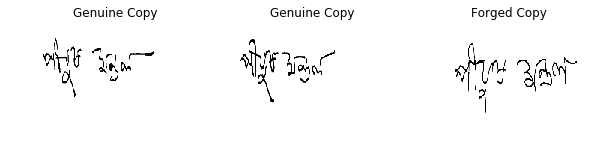

In [16]:
visualize_sample_signature()

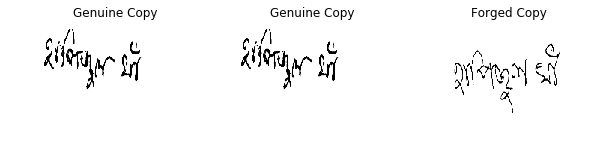

In [17]:
visualize_sample_signature()

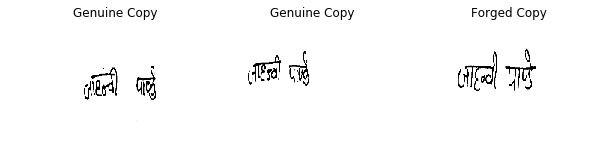

In [18]:
visualize_sample_signature()

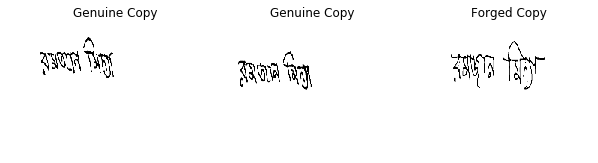

In [19]:
visualize_sample_signature()

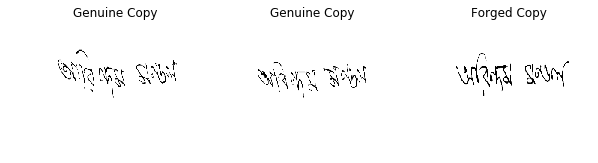

In [20]:
visualize_sample_signature()

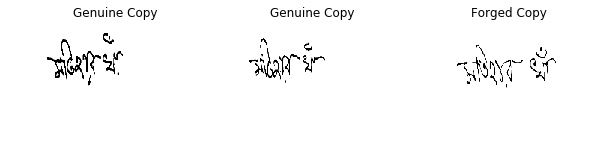

In [21]:
visualize_sample_signature()

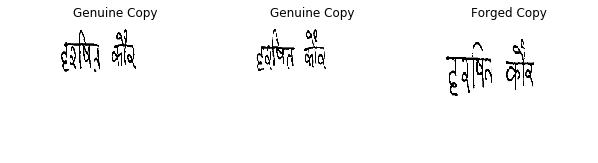

In [22]:
visualize_sample_signature()

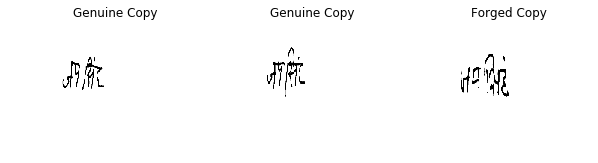

In [23]:
visualize_sample_signature()

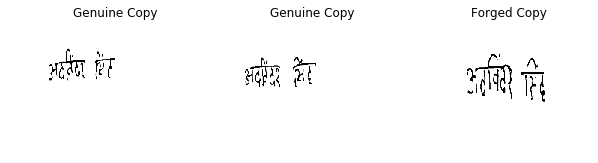

In [24]:
visualize_sample_signature()

##### Generating Batches for training

In [25]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have 
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 300 Genuine-Forged image pairs for one person.
        # In all we have 120 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 120 * 276 = 33120
        # Total number of Genuine-Forged pairs = 120 * 300 = 36000
        # Total no. of data points = 33120 + 36000 = 69120
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

##### Assets for Deep Learning

In [26]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [27]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [28]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

##### The Main Architecture

In [29]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, 
                        init='glorot_uniform', dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2), dim_ordering='tf'))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, init='glorot_uniform', dim_ordering='tf'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform')) # softmax changed to relu
    
    return seq

In [30]:
input_shape=(img_h, img_w, 1)

In [31]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(input=[input_a, input_b], output=distance, name = 'head_model')
# Specify available GPUs
p_model = multi_gpu_model(model, gpus=4)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/soumyasis/.virtualenvs/cvit1/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, data_format="channels_last", input_shape=(155, 220,..., kernel_size=(11, 11), kernel_initializer="glorot_uniform", strides=4, name="conv1_1", activation="relu")`
  
/home/soumyasis/.virtualenvs/cvit1/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(epsilon=1e-06, momentum=0.9, axis=1)`
  import sys


/home/soumyasis/.virtualenvs/cvit1/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D((2, 2), data_format="channels_last")`
  if __name__ == '__main__':
/home/soumyasis/.virtualenvs/cvit1/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, data_format="channels_last", kernel_size=(5, 5), kernel_initializer="glorot_uniform", strides=1, name="conv2_1", activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/home/soumyasis/.virtualenvs/cvit1/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(epsilon=1e-06, momentum=0.9, axis=1)`
  if sys.path[0] == '':
/home/soumyasis/.virtualenvs/cvit1/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D(

In [32]:
batch_sz = 128
num_train_samples = 276*120 + 300*120
num_val_samples = num_test_samples = 276*20 + 300*20
num_train_samples, num_val_samples, num_test_samples

(69120, 11520, 11520)

In [33]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
p_model.compile(loss=contrastive_loss, optimizer=rms)
p_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 155, 220, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 155, 220, 1)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 155, 220, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 155, 220, 1)  0           input_2[0][0]                    
____________________________________________________________________________________________

In [34]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 15 epochs
callbacks = [
    EarlyStopping(patience=15, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('./Weights/signet-bhsig260-full-xavier-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

##### Training

In [38]:

results = p_model.fit_generator(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 100,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
540/540 [==============================] - 366s 677ms/step - loss: 1.0636 - val_loss: 0.6605

Epoch 00001: saving model to ./Weights/signet-bhsig260-full-xavier-001.h5
Epoch 2/100
540/540 [==============================] - 244s 452ms/step - loss: 0.2939 - val_loss: 0.2158

Epoch 00002: saving model to ./Weights/signet-bhsig260-full-xavier-002.h5
Epoch 3/100
540/540 [==============================] - 243s 450ms/step - loss: 0.1329 - val_loss: 0.1375

Epoch 00003: saving model to ./Weights/signet-bhsig260-full-xavier-003.h5
Epoch 4/100
540/540 [==============================] - 245s 453ms/step - loss: 0.0813 - val_loss: 0.1466

Epoch 00004: saving model to ./Weights/signet-bhsig260-full-xavier-004.h5
Epoch 5/100
540/540 [==============================] - 244s 451ms/step - loss: 0.0536 - val_loss: 0.1572

Epoch 00005: saving model to ./Weights/signet-bhsig260-full-xavier-005.h5
Epoch

In [35]:
def compute_accuracy_roc(predictions, labels, plot_far_frr =False):
    '''
    Compute ROC accuracy with a range of thresholds on distances.
    Plot FAR-FRR curves and P-R curves to monitor performance of model on input set.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1) #similar
    ndiff = np.sum(labels == 0) #different
    step = 0.01
    max_acc = 0
    best_thresh = -1
    frr_plot = []
    far_plot = []
    pr_plot = []
    re_plot = []
    ds = []
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d #guessed genuine
        idx2 = predictions.ravel() > d #guessed forged
        tp = float(np.sum(labels[idx1] == 1))
        tn = float(np.sum(labels[idx2] == 0))
        fp = float(np.sum(labels[idx1] == 0))
        fn = float(np.sum(labels[idx2] == 1))
#         print(tp, tn, fp, fn)
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        
        
        acc = 0.5 * (tpr + tnr)
        pr = tp / (tp + fp)
        re = tp / (tp + fn)
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
        
        #if (fp+tn) != 0.0 and (fn+tp) != 0.0:
        far = fp / (fp + tn)
        frr = fn / (fn + tp)
        frr_plot.append(frr)
        pr_plot.append(pr)
        re_plot.append(re)
        far_plot.append(far)
        ds.append(d)
            
    
    if plot_far_frr:
        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(121)
        ax.plot(ds, far_plot, color = 'red')
        ax.plot(ds, frr_plot, color = 'blue')
        ax.set_title('Error rate')
        ax.legend(['FAR', 'FRR'])
        ax.set(xlabel = 'Thresholds', ylabel = 'Error rate')
        
        ax1 = fig.add_subplot(122)
        ax1.plot(ds, pr_plot, color = 'green')
        ax1.plot(ds, re_plot, color = 'magenta')
        ax1.set_title('P-R curve')
        ax1.legend(['Precision', 'Recall'])
        ax.set(xlabel = 'Thresholds', ylabel = 'Error rate')
        
        plt.show()
    return max_acc, best_thresh

#### Load the weights from the epoch which gave the best validation accuracy

In [36]:
def load_and_check_model(weight):
    """
    Print validation Accuracy for all saved weights and choose the best for test set
    (TODO - Perform Ensemble of Weights)
    """
    model.load_weights(weight)

    val_gen = generate_batch(orig_val, forg_val, 1)
    pred, tr_y = [], []
    for i in range(num_val_samples):
        (img1, img2), label = next(val_gen)
        tr_y.append(label)
        pred.append(model.predict([img1, img2])[0][0])

    tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
    return tr_acc, threshold

#### BHSIG260 full dataset with Xavier Initialisation on Uniform Distribution

In [41]:
acc_thresh = []
for i in range(1,39,1):
    acc_thresh.append(load_and_check_model('./Weights/signet-bhsig260-full-'+str(i).zfill(3)+'.h5'))
    print('For model '+str(i)+' Validation Accuracy = ',acc_thresh[i-1][0]*100,'%')


For model 1 Validation Accuracy =  63.37121784596895 %
For model 2 Validation Accuracy =  77.57219553454169 %
For model 3 Validation Accuracy =  81.91654107733535 %
For model 4 Validation Accuracy =  82.03571675575749 %
For model 5 Validation Accuracy =  81.15870561893593 %
For model 6 Validation Accuracy =  82.56760408538459 %
For model 7 Validation Accuracy =  81.17106034302637 %
For model 8 Validation Accuracy =  80.89319586136601 %
For model 9 Validation Accuracy =  82.08091105369888 %
For model 10 Validation Accuracy =  82.93109997075909 %
For model 11 Validation Accuracy =  79.98806480820001 %
For model 12 Validation Accuracy =  79.29754082202507 %
For model 13 Validation Accuracy =  78.39250980829718 %
For model 14 Validation Accuracy =  78.95401315417523 %
For model 15 Validation Accuracy =  79.39519719141322 %
For model 16 Validation Accuracy =  78.53928582614967 %
For model 17 Validation Accuracy =  78.69668965432342 %
For model 18 Validation Accuracy =  79.16482467945352 %


#### BHSIG260 full dataset with He Initialisation on Uniform Distribution

In [42]:
acc_thresh = []
for i in range(1,35,1):
    acc_thresh.append(load_and_check_model('./Weights/signet-bhsig260-full-he_init-'+str(i).zfill(3)+'.h5'))
    print('For model '+str(i)+' Validation Accuracy = ',acc_thresh[i-1][0]*100,'%')

For model 1 Validation Accuracy =  64.878861003861 %
For model 2 Validation Accuracy =  76.08553189468614 %
For model 3 Validation Accuracy =  78.3735284151073 %
For model 4 Validation Accuracy =  78.37494394727709 %
For model 5 Validation Accuracy =  81.20251051256102 %
For model 6 Validation Accuracy =  78.87007909779273 %
For model 7 Validation Accuracy =  79.76647419758484 %
For model 8 Validation Accuracy =  77.0882853856019 %
For model 9 Validation Accuracy =  78.91857577191332 %
For model 10 Validation Accuracy =  78.23329224522307 %
For model 11 Validation Accuracy =  77.36371760500447 %
For model 12 Validation Accuracy =  78.5569657486166 %
For model 13 Validation Accuracy =  78.30188295165395 %
For model 14 Validation Accuracy =  77.84726660958286 %
For model 15 Validation Accuracy =  77.80805023079287 %
For model 16 Validation Accuracy =  77.81067611160908 %
For model 17 Validation Accuracy =  77.31642350508837 %
For model 18 Validation Accuracy =  77.63206845097844 %
For mo

In [37]:
def test_model(weight):
    model.load_weights(weight)

    test_gen = generate_batch(orig_test, forg_test, 1)
    pred, tr_y = [], []
    for i in range(num_test_samples):
        (img1, img2), label = next(test_gen)
        tr_y.append(label)
        pred.append(model.predict([img1, img2])[0][0])

    tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y), plot_far_frr = True)
    return tr_acc, threshold

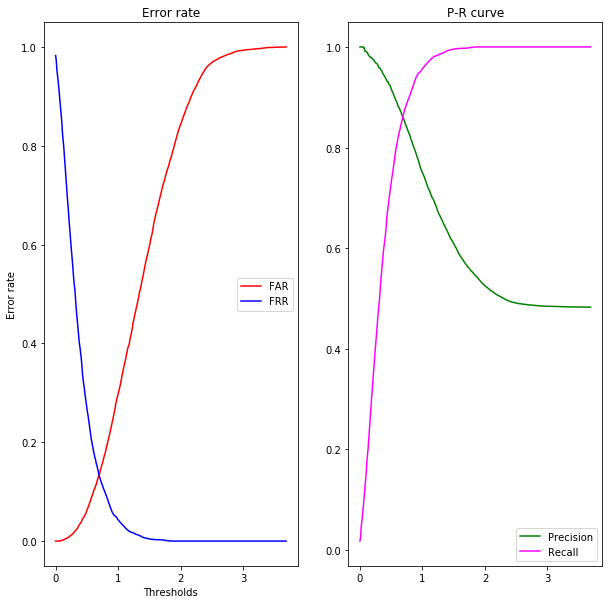

(0.8668020617063397, 0.71)

In [38]:
acc, threshold = test_model('./Weights/signet-bhsig260-full-010.h5')
acc, threshold

#### Accuracy = 86.68% and Threshold = 0.71 Using Xavier Initialisation on Uniform distribution
Thus if the difference score is less than 0.71 we predict the test image as Genuine and if the difference score is greater than 0.71 we predict it to be as forged

#### Below we see some sample results

In [39]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_gen = generate_batch(orig_test, forg_test, 1)
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

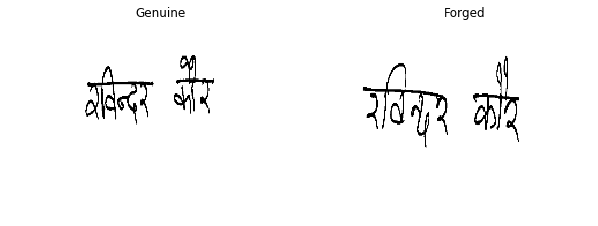

Difference Score =  2.356821
Its a Forged Signature


In [40]:
predict_score()

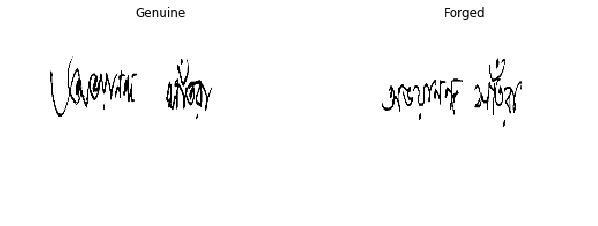

Difference Score =  0.7681368
Its a Forged Signature


In [41]:
predict_score()

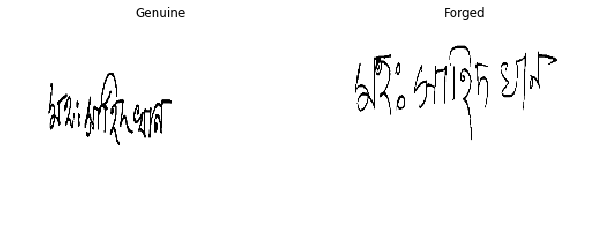

Difference Score =  0.80822784
Its a Forged Signature


In [42]:
predict_score()

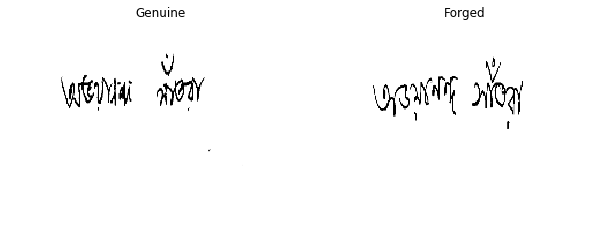

Difference Score =  1.2253996
Its a Forged Signature


In [43]:
predict_score()

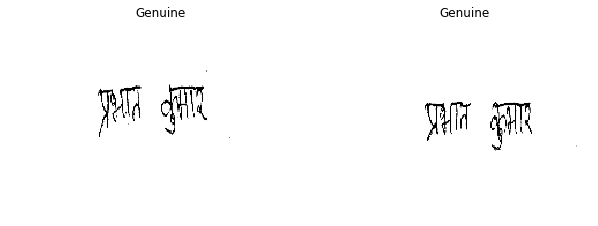

Difference Score =  0.5929343
Its a Genuine Signature


In [44]:
predict_score()

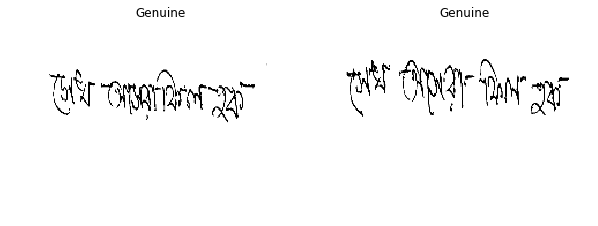

Difference Score =  0.39658493
Its a Genuine Signature


In [45]:
predict_score()

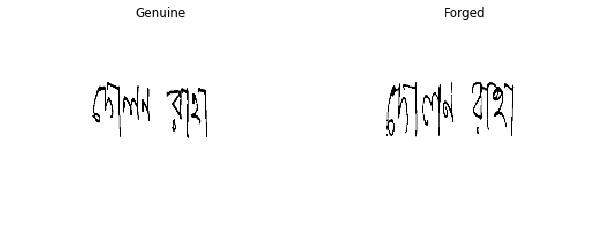

Difference Score =  0.46831188
Its a Genuine Signature


In [46]:
predict_score()

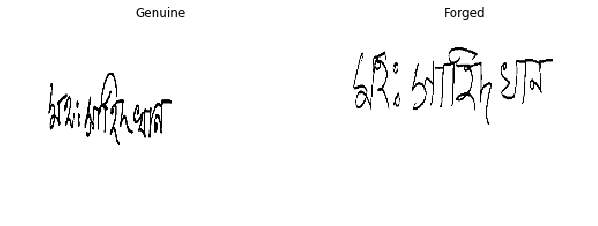

Difference Score =  0.7604083
Its a Forged Signature


In [47]:
predict_score()

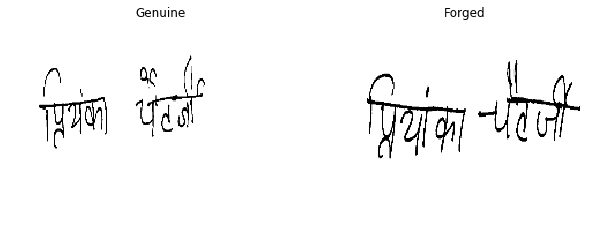

Difference Score =  1.8284729
Its a Forged Signature


In [48]:
predict_score()

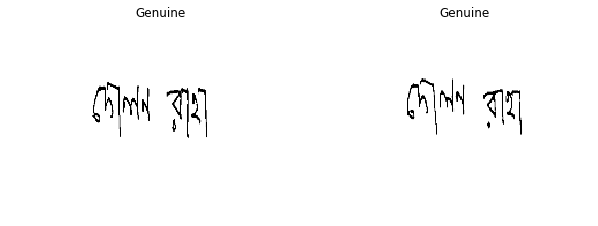

Difference Score =  1.8374792
Its a Forged Signature


In [49]:
predict_score()

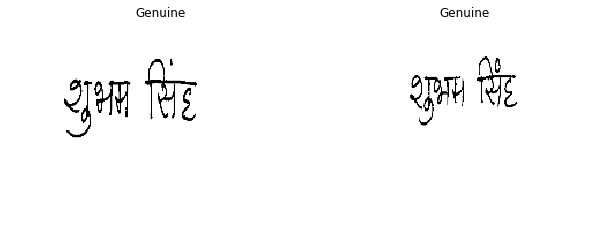

Difference Score =  1.0332507
Its a Forged Signature


In [50]:
predict_score()

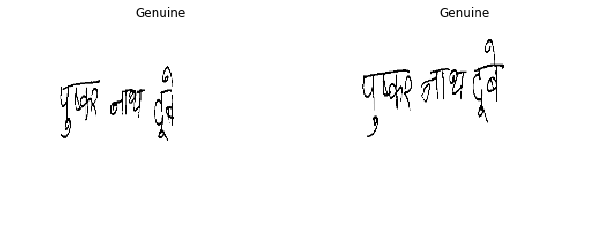

Difference Score =  0.31703317
Its a Genuine Signature


In [51]:
predict_score()

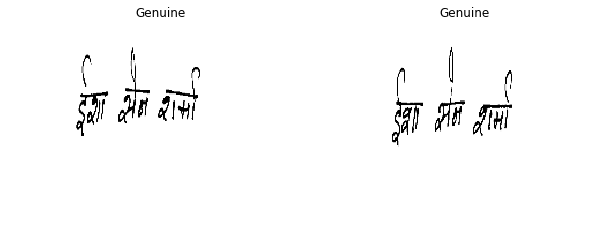

Difference Score =  0.16137493
Its a Genuine Signature


In [52]:
predict_score()

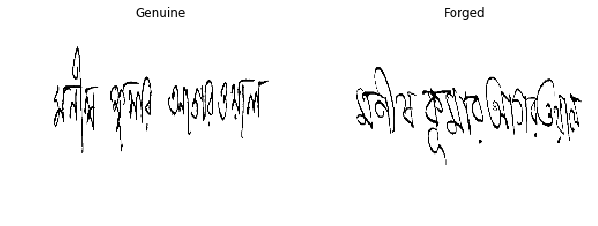

Difference Score =  0.8448042
Its a Forged Signature


In [53]:
predict_score()

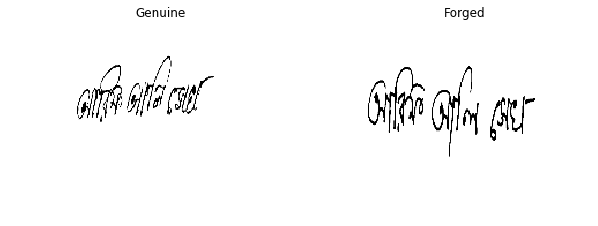

Difference Score =  1.4969537
Its a Forged Signature


In [54]:
predict_score()

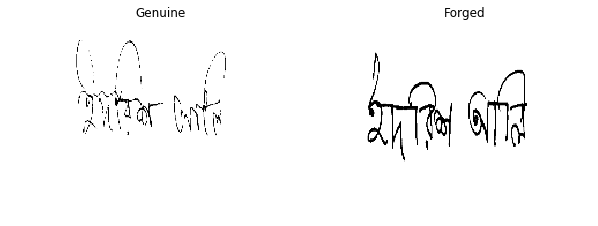

Difference Score =  2.242569
Its a Forged Signature


In [55]:
predict_score()

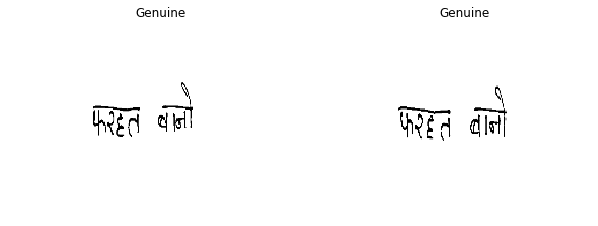

Difference Score =  0.41018537
Its a Genuine Signature


In [56]:
predict_score()

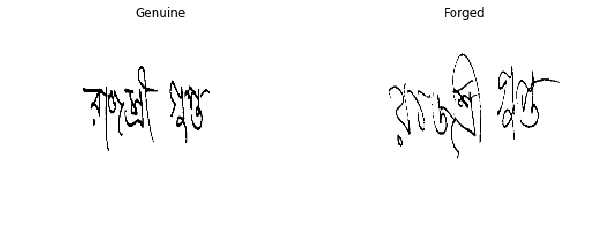

Difference Score =  2.013484
Its a Forged Signature


In [57]:
predict_score()

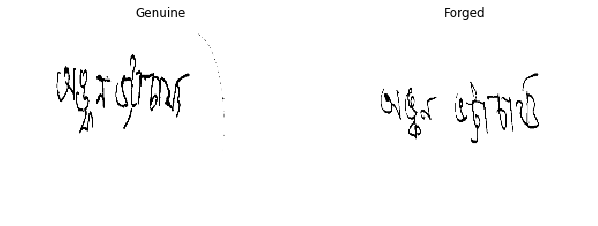

Difference Score =  0.9356357
Its a Forged Signature


In [58]:
predict_score()

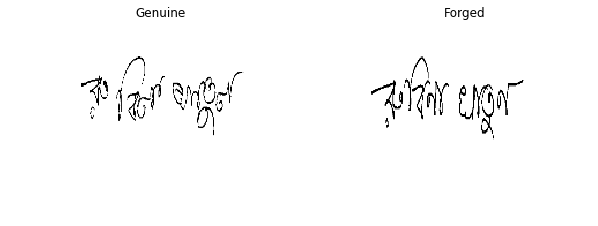

Difference Score =  0.92475945
Its a Forged Signature


In [59]:
predict_score()

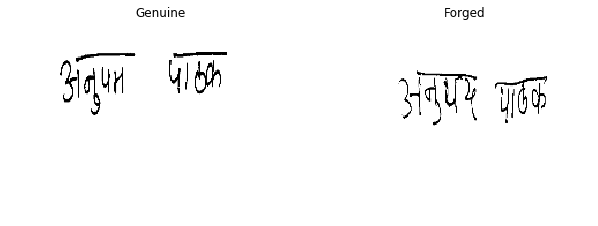

Difference Score =  0.9936217
Its a Forged Signature


In [60]:
predict_score()

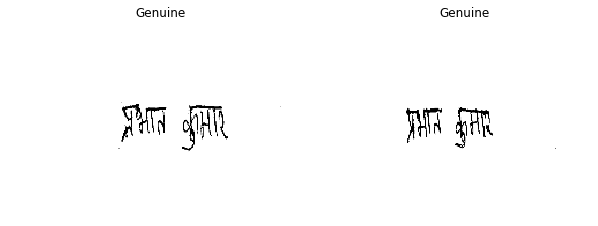

Difference Score =  0.1923608
Its a Genuine Signature


In [61]:
predict_score()

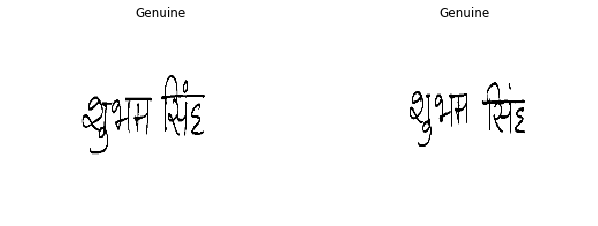

Difference Score =  0.79246
Its a Forged Signature


In [62]:
predict_score()

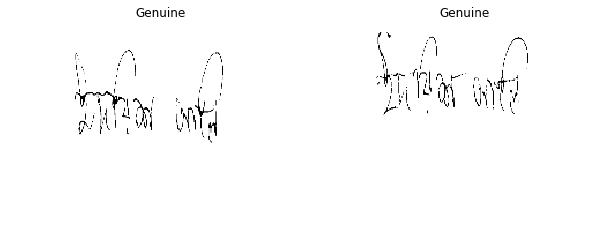

Difference Score =  0.115312956
Its a Genuine Signature


In [63]:
predict_score()

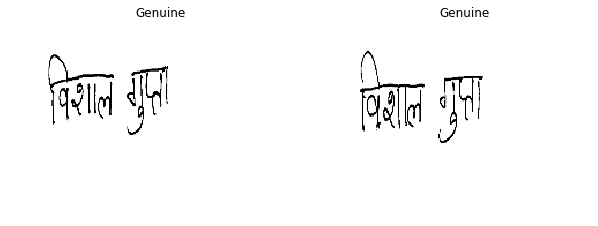

Difference Score =  0.14766902
Its a Genuine Signature


In [64]:
predict_score()

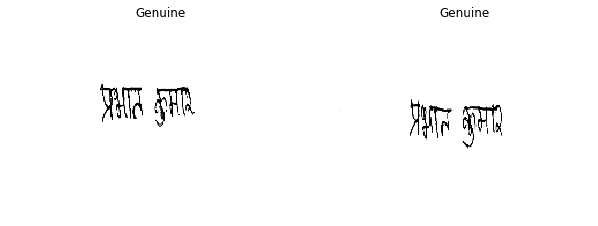

Difference Score =  0.26181468
Its a Genuine Signature


In [65]:
predict_score()

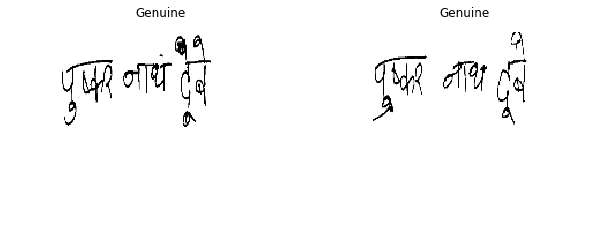

Difference Score =  0.35424778
Its a Genuine Signature


In [66]:
predict_score()

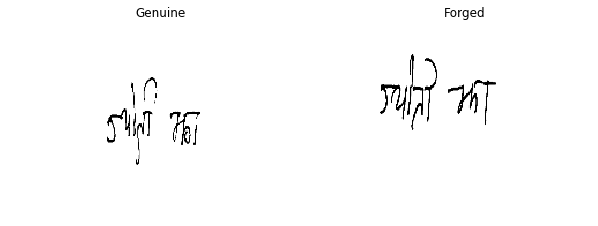

Difference Score =  0.93090034
Its a Forged Signature


In [67]:
predict_score()

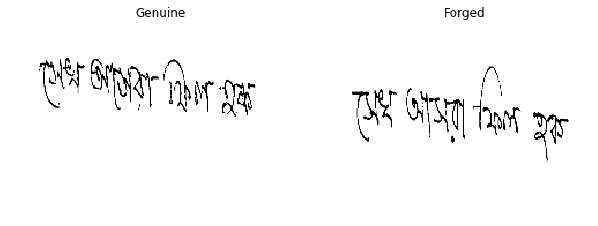

Difference Score =  0.9641699
Its a Forged Signature


In [68]:
predict_score()

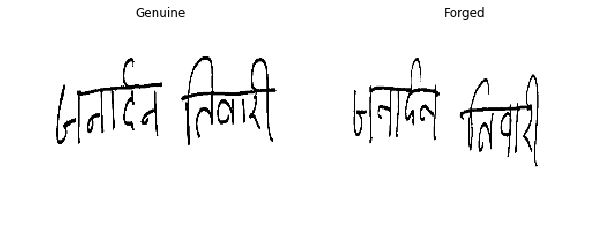

Difference Score =  1.0745736
Its a Forged Signature


In [69]:
predict_score()

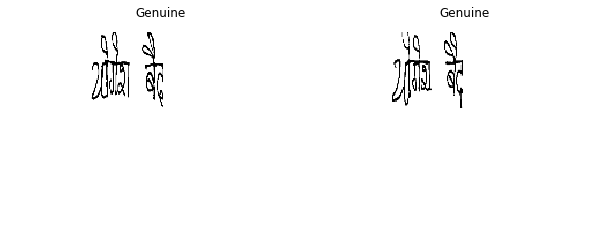

Difference Score =  0.18710439
Its a Genuine Signature


In [70]:
predict_score()

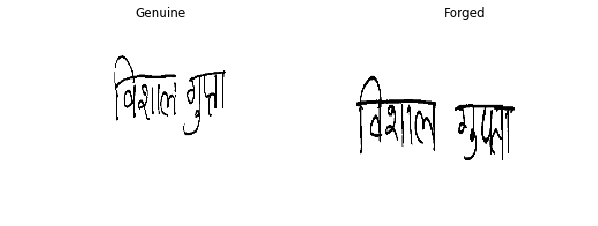

Difference Score =  2.0787163
Its a Forged Signature


In [71]:
predict_score()

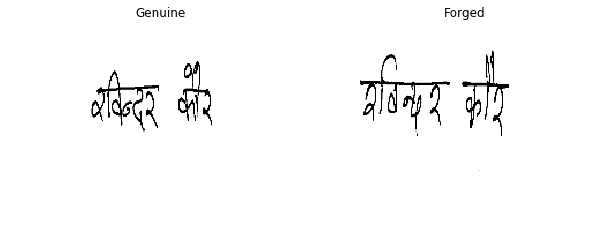

Difference Score =  1.5586433
Its a Forged Signature


In [72]:
predict_score()

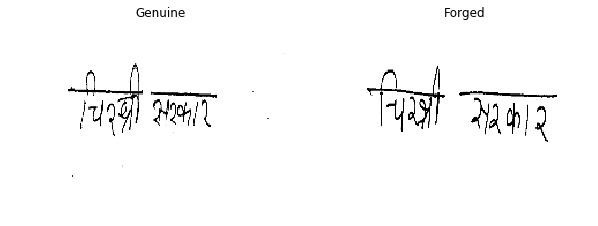

Difference Score =  0.97677225
Its a Forged Signature


In [73]:
predict_score()

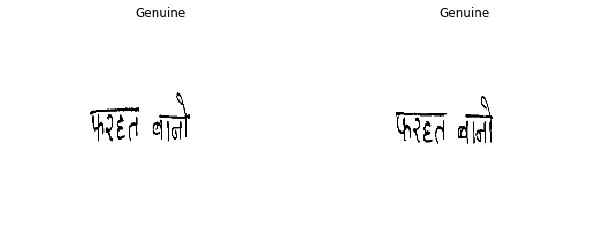

Difference Score =  0.17374566
Its a Genuine Signature


In [74]:
predict_score()

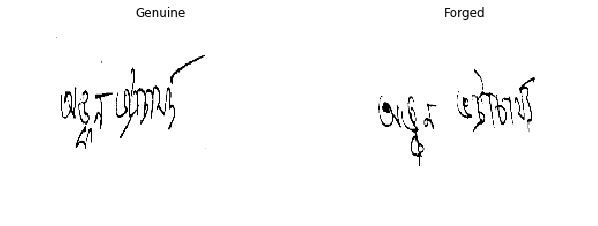

Difference Score =  0.7657533
Its a Forged Signature


In [75]:
predict_score()

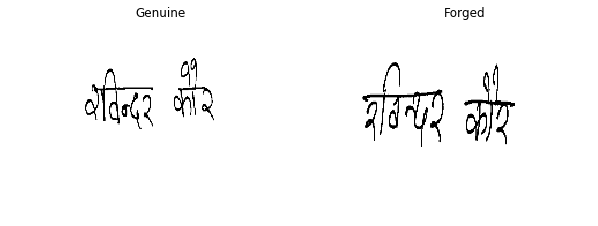

Difference Score =  1.9527236
Its a Forged Signature


In [76]:
predict_score()

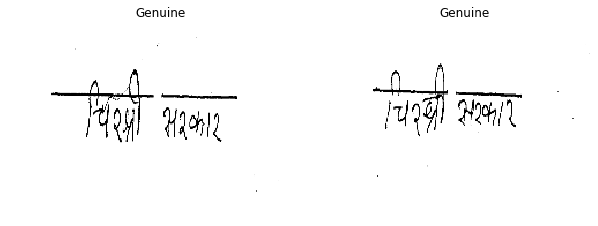

Difference Score =  0.90996814
Its a Forged Signature


In [77]:
predict_score()

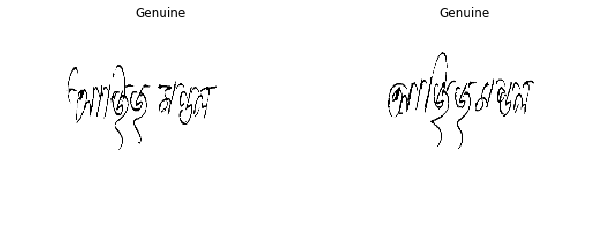

Difference Score =  0.64600396
Its a Genuine Signature


In [78]:
predict_score()

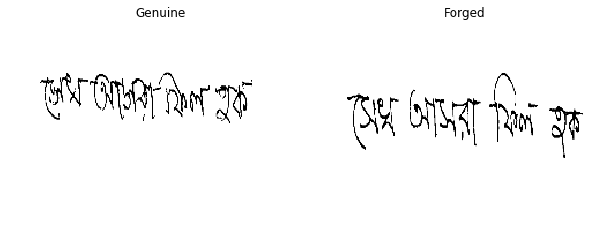

Difference Score =  0.90028965
Its a Forged Signature


In [79]:
predict_score()

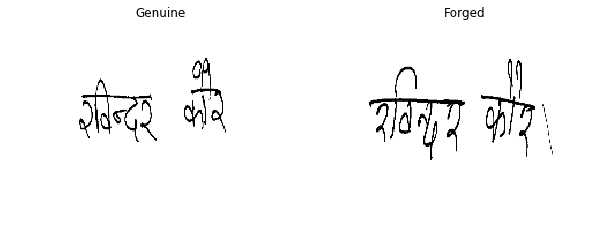

Difference Score =  1.8098075
Its a Forged Signature


In [80]:
predict_score()

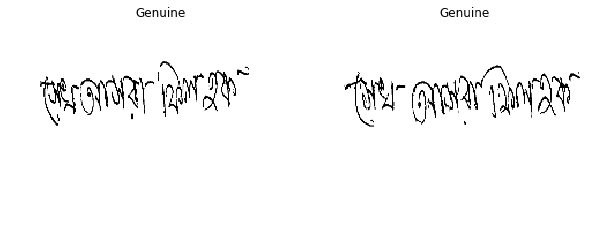

Difference Score =  0.41194844
Its a Genuine Signature


In [81]:
predict_score()

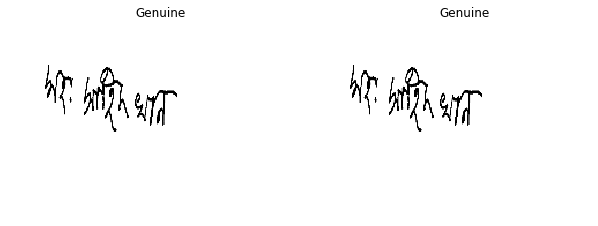

Difference Score =  0.0
Its a Genuine Signature


In [82]:
predict_score()

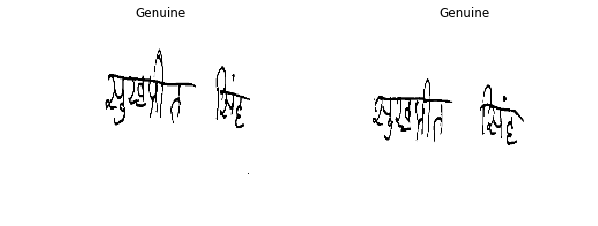

Difference Score =  0.7582232
Its a Forged Signature


In [83]:
predict_score()

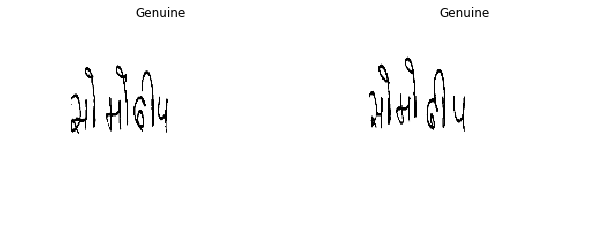

Difference Score =  0.13657396
Its a Genuine Signature


In [84]:
predict_score()

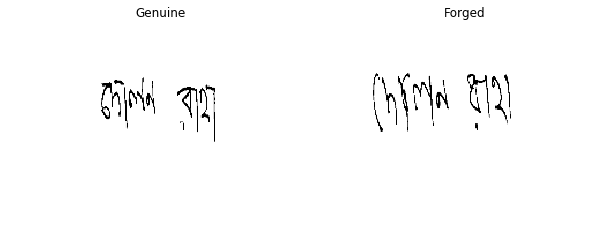

Difference Score =  0.82679504
Its a Forged Signature


In [85]:
predict_score()

#### Visualising Network Activations

The representations learned by convnets are highly amenable to visualization, in large part because they’re representations of visual concepts. Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its activation, the output of the activation function). This gives a view into how an input is decomposed into the different filters learned by the network. Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image.

Intermediate activations are useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters.

In order to extract the feature maps we want to look at, we’ll create a Keras model that takes batches of images as input, and outputs the activations of all convolution and pooling layers. To do this, we’ll use the Keras class Model. A model is instantiated using two arguments: an input tensor (or list of input tensors) and an output tensor (or list of output tensors). The resulting class is a Keras model, just like the Sequential models, mapping the specified inputs to the specified outputs. What sets the Model class apart is that it allows for models with multiple outputs, unlike Sequential.

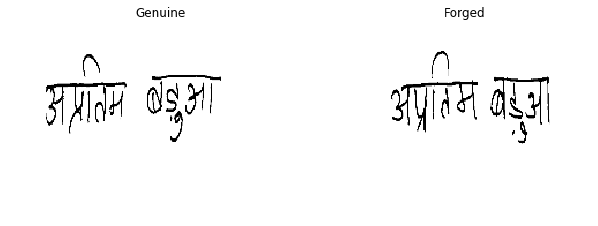

/home/soumyasis/.virtualenvs/cvit1/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


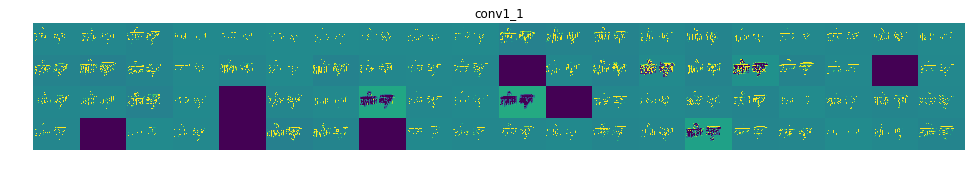

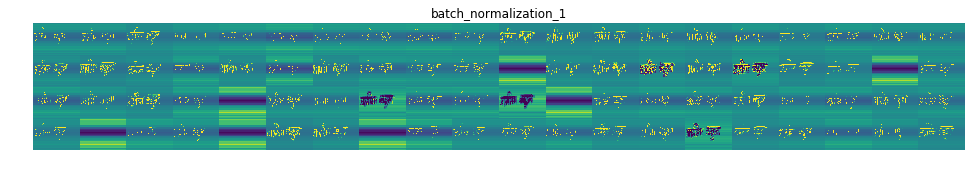

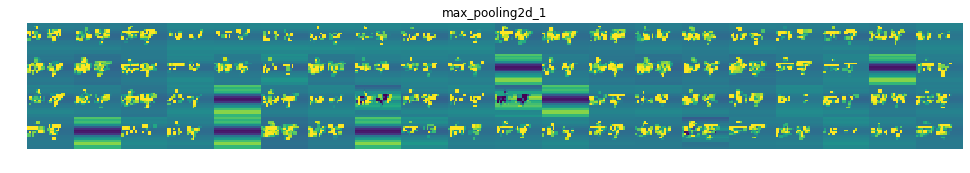

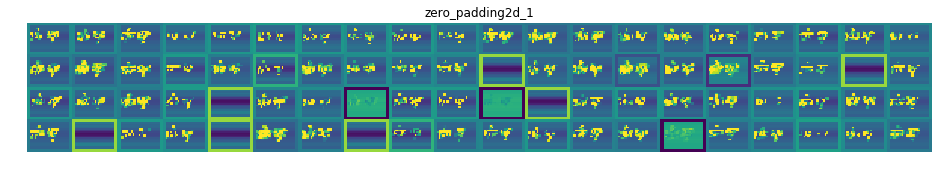

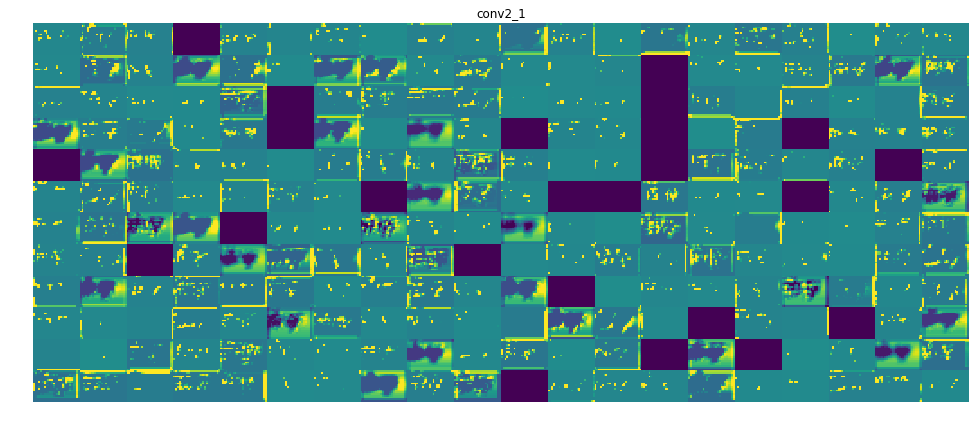

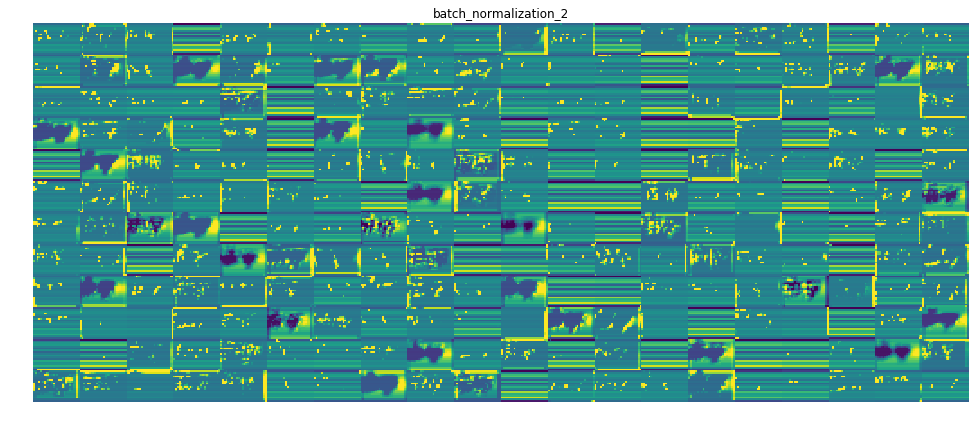

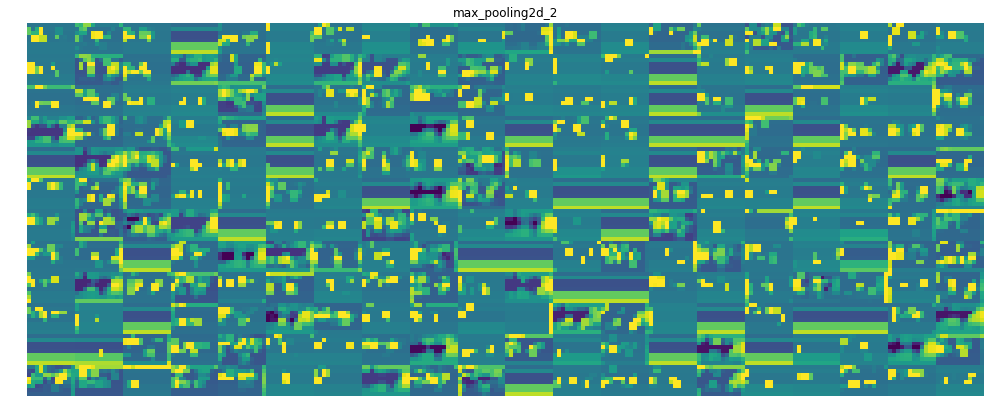

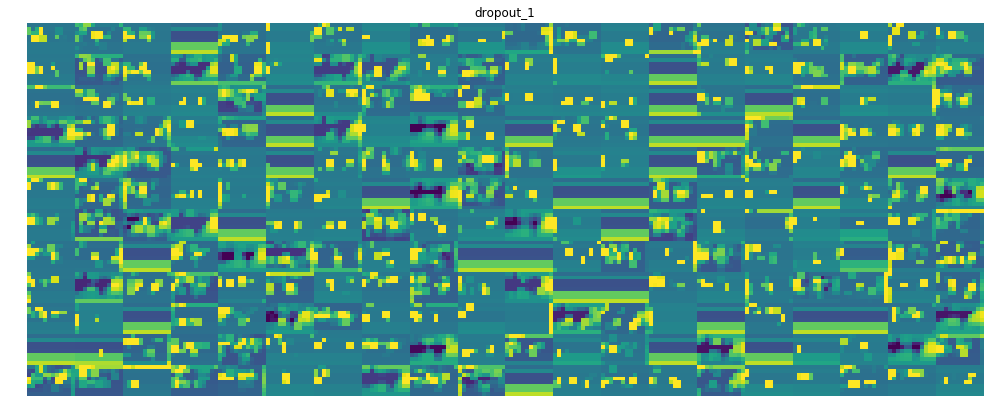

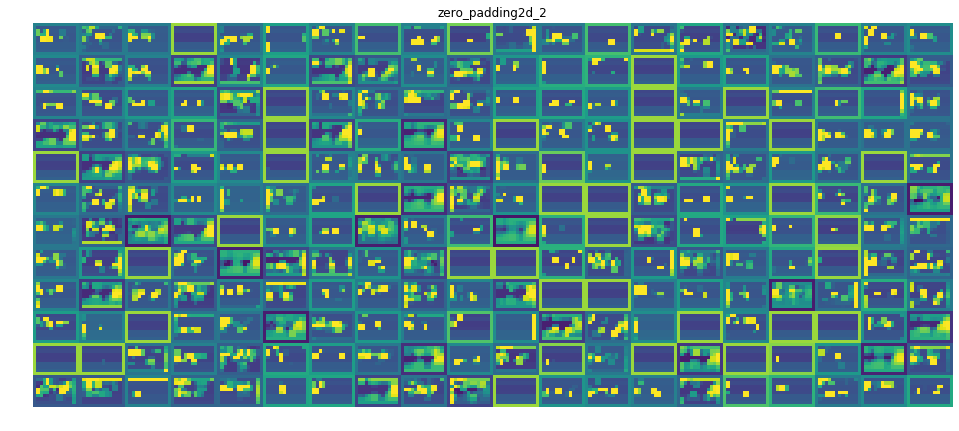

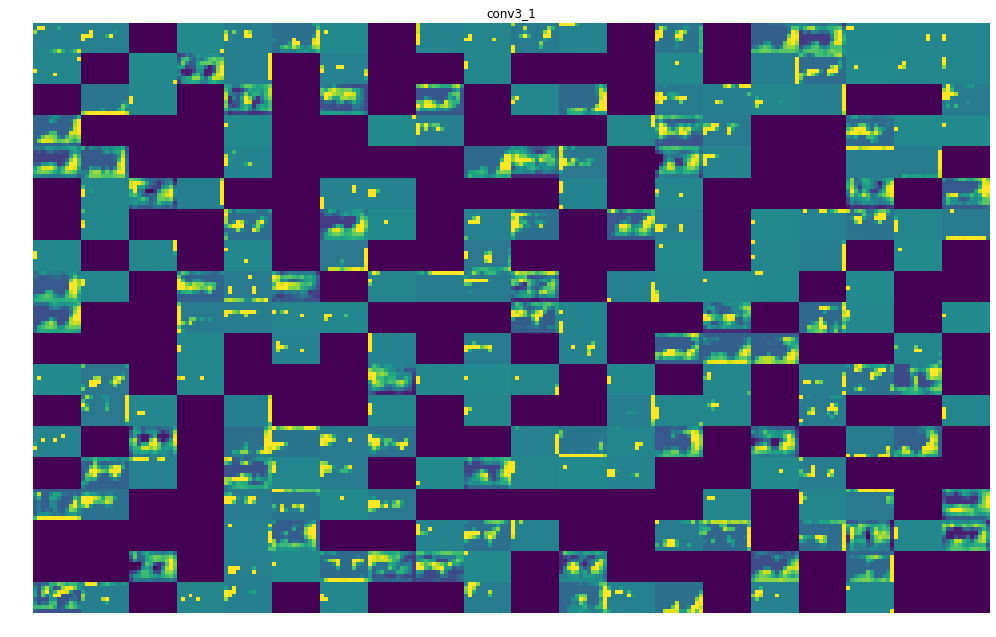

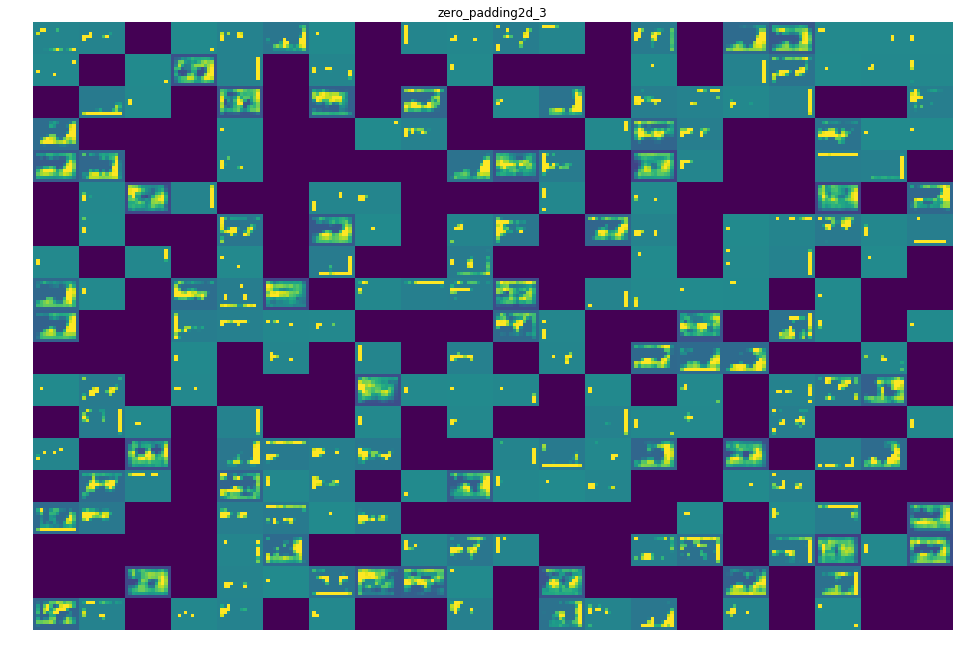

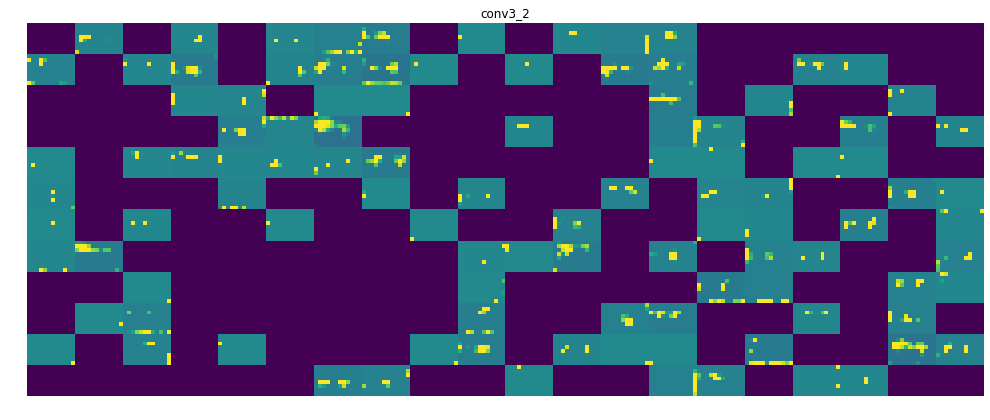

In [86]:
test_gen = generate_batch(orig_test, forg_test, 1)
test_point, test_label = next(test_gen)
img1, img2 = test_point[0], test_point[1]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.imshow(np.squeeze(img1), cmap='gray')
ax2.imshow(np.squeeze(img2), cmap='gray')
ax1.set_title('Genuine')
if test_label == 1:
    ax2.set_title('Genuine')
else:
    ax2.set_title('Forged')
ax1.axis('off')
ax2.axis('off')
plt.show()

branched_model = base_network
layer_outputs = [layer.get_output_at(-1) for layer in branched_model.layers[:20]] # Extracts the outputs of the top 12 layers
inputs_at_node = branched_model.get_input_at(0)
print


activation_model = models.Model(inputs=inputs_at_node, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict([img1]) # Returns a list of five Numpy arrays: one array per layer activation
layer_names = []
for layer in branched_model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 20
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size_c = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    size_r = layer_activation.shape[2] #The feature map has shape (1, size, size, n_features).
#     print(layer_activation.shape)
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size_c * n_cols, images_per_row * size_r))
#     print(display_grid.shape)
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
#             print(row * size_r , (row + 1) * size_r,col * size_c  ,(col + 1) * size_c)
#             print(channel_image.shape)
            display_grid[col * size_c : (col + 1) * size_c,row * size_r : (row + 1) * size_r] = channel_image # Displays the grid
                         
    scale = 1. / (size_c+size_r/2)
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')